# Introduction
## Problem Description
There are tons of games out there, it is almost impossible for me to tell what to play next. I must trust the recommender system of Steam or Epic Games, but what about when I am not playing on my PC?. 
There are lots of available reviews and lists out there to check out, but this project is the opportunity to create my own recommender system and look out for what to play after I complete a game I like.

## Dataset Description
Searching for datasets on Kaggle I found this database containing information from 13385 games (I would need more lives than DK to play all of them, and also a lot of money). 
Dataset is called: "metacritic-games-12-23-2024". We need to know what info it contains before going on.

# EDA & Initial data preparations
## 1. Step one: Loading data¶
This dataset contains 2 separate but related .csv called "12_23_2024_simple_data.csv" and "12_23_2024_detailed_data.csv"
This will load them and merge them.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # clean output on histograms
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
simple_df = pd.read_csv('../input/metacritic-games-12-23-2024/12_23_2024_simple_data.csv')
detailed_df = pd.read_csv('../input/metacritic-games-12-23-2024/12_23_2024_detailed_data.csv')

df = pd.merge(simple_df, detailed_df, on='name', how='inner')
print(df.shape)
print(df.info())

(13385, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13385 entries, 0 to 13384
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0_x             13385 non-null  int64 
 1   name                     13385 non-null  object
 2   release_date             13385 non-null  object
 3   game_page                13385 non-null  object
 4   summary                  13345 non-null  object
 5   score                    13385 non-null  object
 6   Unnamed: 0_y             13385 non-null  int64 
 7   metacritic_review_count  13384 non-null  object
 8   metacritic_review_score  13385 non-null  object
 9   user_review_count        11832 non-null  object
 10  user_review_score        13385 non-null  object
 11  developer                13375 non-null  object
 12  publisher                13375 non-null  object
 13  platforms                13385 non-null  object
 14  genres                   1

In [3]:
#df.head()

## 2. Step two: Manual inspection and droping columns that are clearly unnecesary

On the manual inspection this are variables:

**0   Unnamed: 0_x:** just indexing column, this is not informative. <br>
**1   name:** String - game names. <br>
**2   release_date:** String on date of release <br>
**3   game_page:** String - also not informative for training models, but it can help people check more details of a game. <br>
**4   summary:** String - summary of the game, it seems like we could use it with NLP or Term Frequency Inverse Document Frequency, but I believe it is out of our scope here, it will not be used on the training for now. <br>
**5   score:** number - 0-100 on a continuous variable <br>
**6   Unnamed: 0_y:** just indexing column, this is not informative. <br>
**7   metacritic_review_count:** Number - number of critics  <br>
**8   metacritic_review_score:** Number - 0-100 on score of games according to metacritic a continuous variable <br>
**9   user_review_count:** Number - 0-100 on score of games according to players a continuous variable <br>
**10  user_review_score:** Number - number of critics <br>
**11  developer:** String on developer <br>
**12  publisher:** String on publisher <br>
**13  platforms:** String list - Multilabel on platforms  <br> 
**14  genres:** String on developer <br>
**15  esrb:** String on developer <br> 
**16  must_play:** Boolean on yes or no

In [4]:
df = df.drop(['Unnamed: 0_x', 'score', 'Unnamed: 0_y'], axis=1)

In [5]:
# df.head()

## 3. Step three: String cleaning - string to number on release date

After dropping the unnecessary columns, on the manual inspection there is a clear pattern on most of the string columns with apparently important information, they are going to be cleaned for future analysis.


In [6]:
df['release_date'] = df['release_date'].str[7:]
df['metacritic_review_count'] = df['metacritic_review_count'].str.replace(r'[a-zA-Z\s]', '', regex=True).str.strip() # elimina todas las letras
df['user_review_count'] = df['user_review_count'].str.replace(r'[a-zA-Z\s]', '', regex=True).str.strip()
df['user_review_count'] = df['user_review_count'].str.replace(',', '', regex=False).str.strip()
df['user_review_score'] = df['user_review_score'].str.replace('.', '', regex=False).str.strip()
df['developer'] = df['developer'].str.replace('Developer:', '').str.strip()
df['publisher'] = df['publisher'].str.replace('Publisher:', '').str.strip()
df['platforms'] = df['platforms'].str.replace('[', '').str.strip()
df['platforms'] = df['platforms'].str.replace(']', '').str.strip()
df['platforms'] = df['platforms'].str.replace("'", '', regex=False).str.strip()
df['genres'] = df['genres'].str.replace('[', '').str.strip()
df['genres'] = df['genres'].str.replace(']', '').str.strip()
df['genres'] = df['genres'].str.replace("'", '', regex=False).str.strip()

In [7]:
# df.head()

## 4. Step four: Checking missing information & variable type

In [8]:
df.isnull().sum()

name                          0
release_date                  0
game_page                     0
summary                      40
metacritic_review_count       1
metacritic_review_score       0
user_review_count          1553
user_review_score             0
developer                    10
publisher                    10
platforms                     0
genres                        0
esrb                       2101
must_play                     0
dtype: int64

In [9]:
# non numeric values ?
non_numeric = df[~df['user_review_score'].str.match(r'^\d+(\.\d+)?$', na=False)]
print(non_numeric['user_review_score'].unique())

non_numeric = df[~df['metacritic_review_score'].str.match(r'^\d+(\.\d+)?$', na=False)]
print(non_numeric['metacritic_review_score'].unique())

['tbd']
['tbd']


In [10]:
df.dropna(subset=['metacritic_review_count'], inplace=True)
df.reset_index(drop=True, inplace=True)
df['metacritic_review_count'] = df['metacritic_review_count'].astype('Int64')
#df['metacritic_review_score'] = df['metacritic_review_score'].replace('tbd', np.nan)
df['metacritic_review_score'] = df['metacritic_review_score'].astype('Int64')
df['user_review_count'] = df['user_review_count'].astype('Int64')
df['user_review_score'] = df['user_review_score'].replace('tbd', np.nan)
df['user_review_score'] = df['user_review_score'].astype('Int64')
df['release_date'] = df['release_date'].astype('Int64')
df['must_play'] = df['must_play'].astype('Int64')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13384 entries, 0 to 13383
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   name                     13384 non-null  object
 1   release_date             13384 non-null  Int64 
 2   game_page                13384 non-null  object
 3   summary                  13344 non-null  object
 4   metacritic_review_count  13384 non-null  Int64 
 5   metacritic_review_score  13384 non-null  Int64 
 6   user_review_count        11832 non-null  Int64 
 7   user_review_score        11832 non-null  Int64 
 8   developer                13374 non-null  object
 9   publisher                13374 non-null  object
 10  platforms                13384 non-null  object
 11  genres                   13384 non-null  object
 12  esrb                     11284 non-null  object
 13  must_play                13384 non-null  Int64 
dtypes: Int64(6), object(8)
memory usage: 1

In [11]:
# df.isnull().sum()

## 5. Step five: Plots

Here we see histograms for numerical columns, posible categories and some plots for categorical columns.

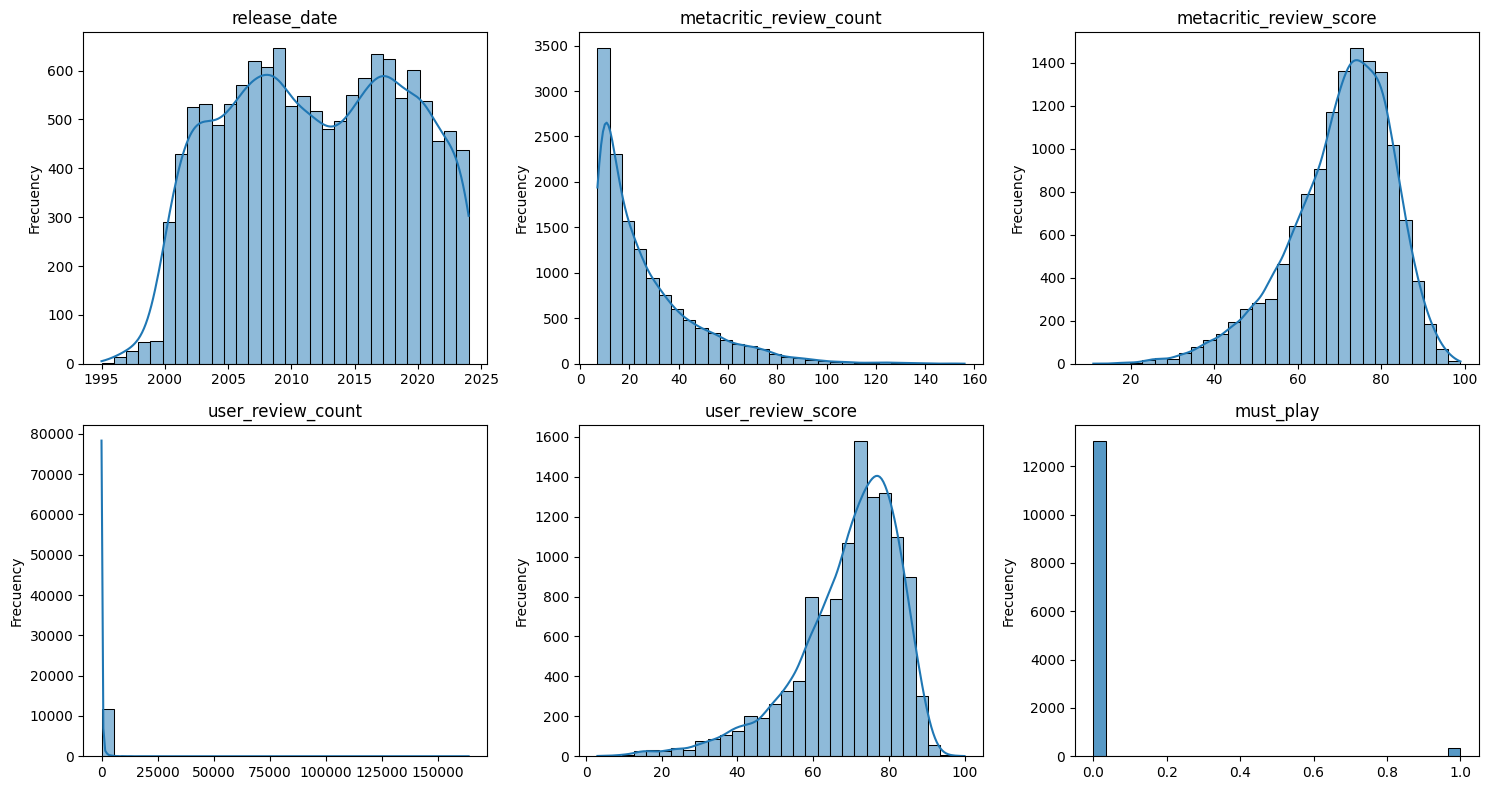

In [12]:
# Plotting numerical columns 
num_cols = df.select_dtypes(include=['number', 'bool']).columns

# Subplots layout
n_cols = 3  # columns in line
n_rows = (len(num_cols) + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 5, n_rows * 4))

for idx, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, idx)
    sns.histplot(data=df, x=col, kde=True if df[col].nunique() > 5 else False, bins=30)
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('Frecuency')

plt.tight_layout()
plt.show()


In [13]:
print((df['must_play'] == True).sum())


326


In [14]:
for i, col in enumerate(df.columns, start=1):
    if col  in ['developer', 'publisher', 'platforms', 'genres', 'esrb' ]:
        print(f"{i}. {col}")
        print(df[col].unique())
        print("-------------")

9. developer
['Nintendo' 'Namco' 'Rockstar North' ... 'Fredaikis AB' 'Pure FPS'
 'Gravity']
-------------
10. publisher
['Nintendo' 'Namco' 'Rockstar Games' ... 'D2C Games' 'Poisoft'
 'Backbone Entertainment']
-------------
11. platforms
['Nintendo 64' 'Dreamcast, iOS (iPhone/iPad), Xbox 360'
 'PlayStation 3, Xbox 360, PC' ... 'Game Boy Advance, Wii, DS, PC'
 'Xbox 360, PlayStation 3, Wii U, 3DS, PC' 'PC, DS, Game Boy Advance, Wii']
-------------
12. genres
['Open-World Action' '3D Fighting' '3D Platformer' 'Skating' 'FPS'
 'Football Sim' 'Linear Action Adventure' 'Survival' 'Western RPG'
 'Compilation' 'Visual Novel' 'Action RPG' 'Auto Racing Sim'
 'Action Adventure' '2D Platformer' 'JRPG' 'Third Person Shooter'
 '4X Strategy' 'Auto Racing' '2D Fighting' 'Real-Time Strategy' 'Arcade'
 'Management' 'Command RTS' 'Skiing' 'Sandbox' 'Soccer Sim' 'Rhythm'
 '"2D Beat-Em-Up"' 'Basketball Sim' 'Roguelike' 'Future Racing' 'MMORPG'
 'Application' 'Hockey Sim' 'Virtual Life' 'Turn-Based Tactics

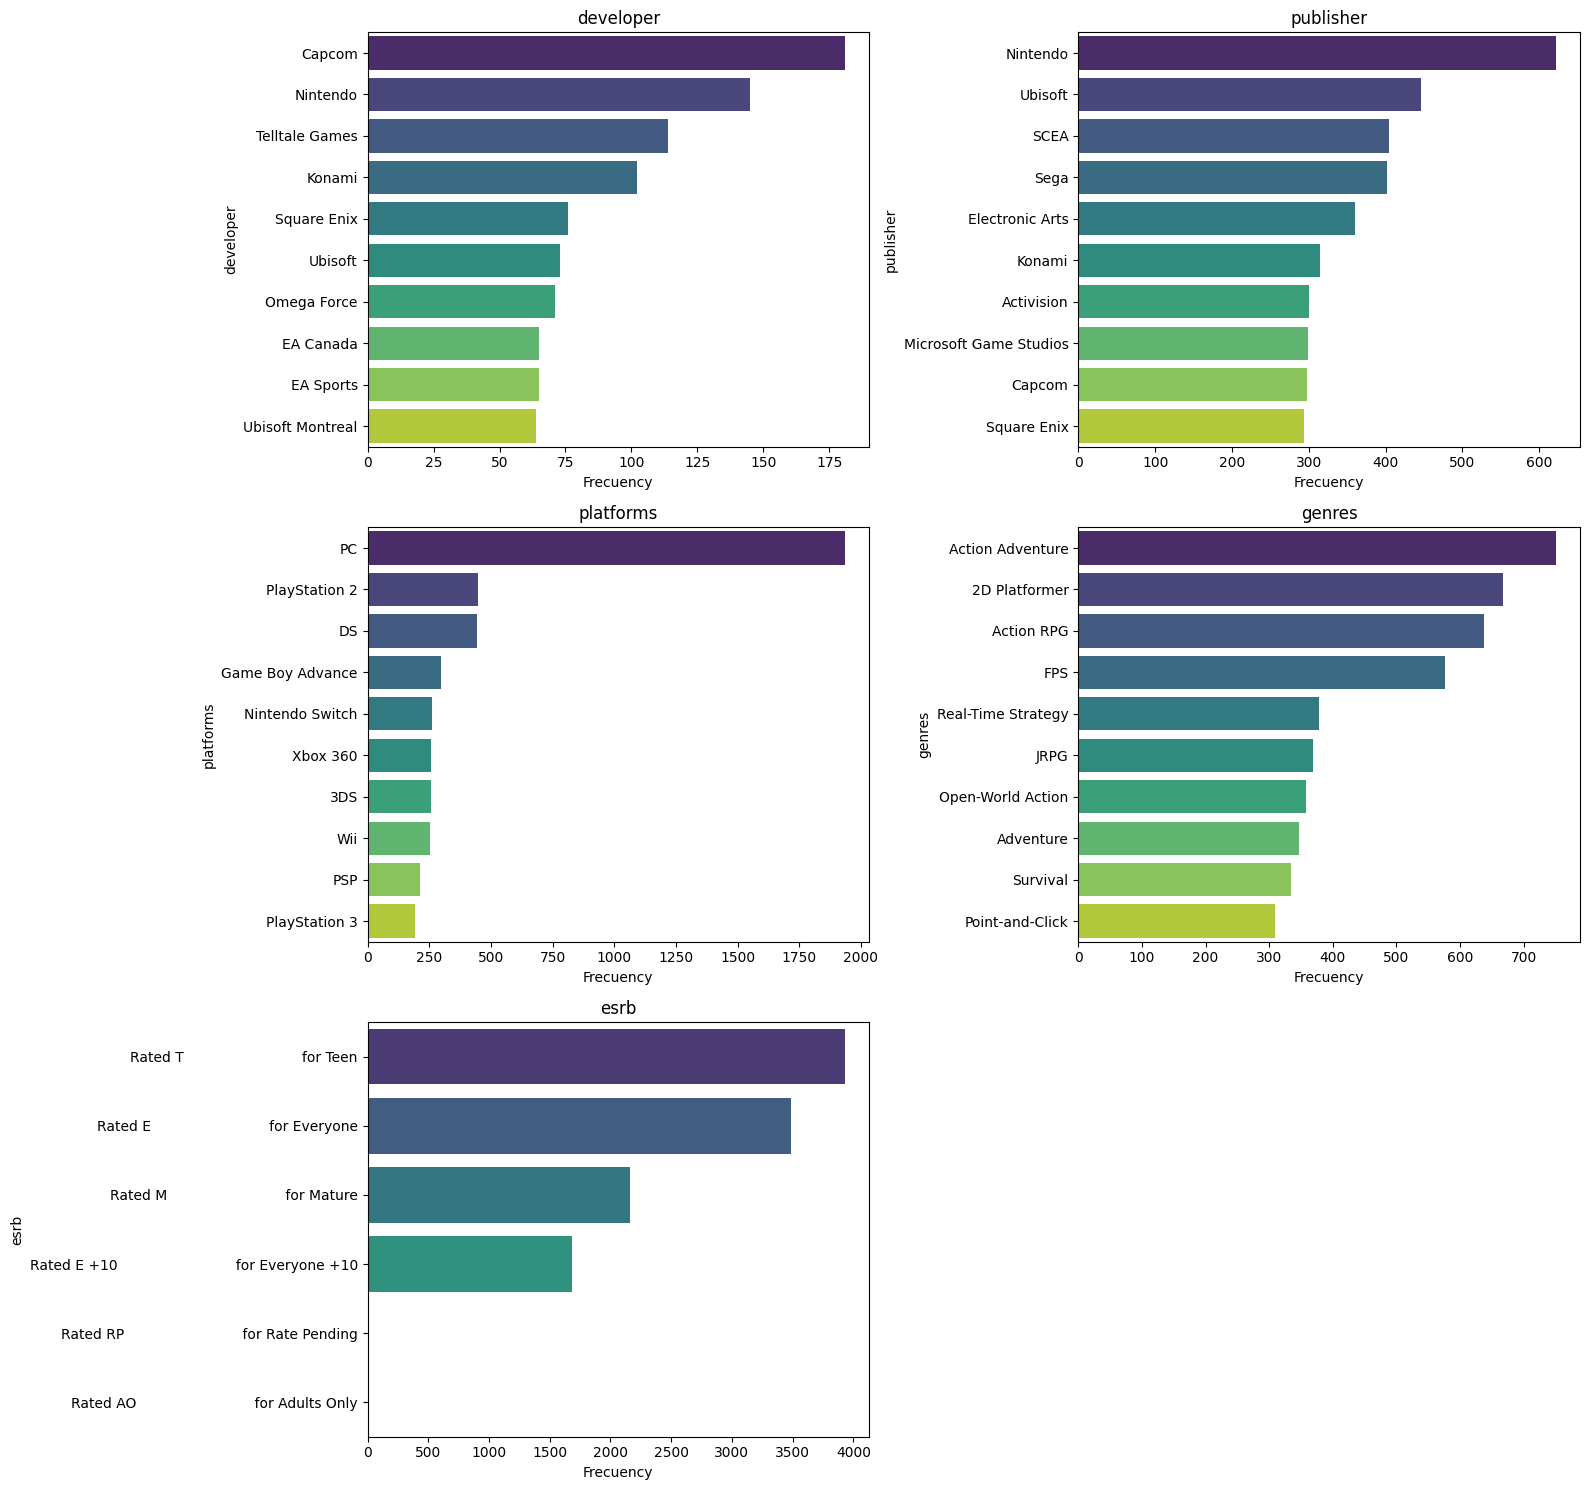

In [15]:
# Categorical columns
cat_cols = df.select_dtypes(include=['object']).columns
cat_cols = [col for col in cat_cols if col not in ['name', 'summary', 'game_page']]

# layout
n_cols = 2
n_rows = (len(cat_cols) + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 8, n_rows * 5))

for idx, col in enumerate(cat_cols, 1):
    plt.subplot(n_rows, n_cols, idx)
    
    # Contar los 10 valores más frecuentes
    top_categories = df[col].value_counts().nlargest(10)
    
    sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')
    plt.title(col)
    plt.xlabel('Frecuency')

plt.tight_layout()
plt.show()


## Summary of findings
So, as we can see we can see games from 1995 to 2024, most of them from 2000 to 2024. Metacritic on games is based on few reviews for the majority of the games, and as a bell shaped with a long-left tail games are rated mostly between 60 and 80 points.
From users there is less data and reviews, and people seem to be harder that critics putting less score.
According to this people must play are only 326 games.
Nintendo is the top publisher on this database, and the second developer. Most of the games (by far) can be played on PC. Genres are well distributed, and most games are developed for Teen or Everyone. 


# Recomender System

While there many recommender algorithms and techniques, most of them can be classified as collaborative filtering, content filtering and context filtering.

The database in our hands does not contain user rating matrix, so is impossible to determine what type of player I am and use collaborative filtering approach based on similar users. 

**Les’t go with a content filtered.**

We need to convert everything to a games x features matrix, and then we will use some aproaches and test them.
First each game will be a feature vector and cosine similarity can be calculated. Then we can use KNN and find nearest neightbors. Finally, agglomerative cluster can create subgroups for us to explore. 

In that way user select a game, and our recommender system is going to show some similar games.

For tunning up this recommender system we can have some weights on features and search filtering (by generes of platform).
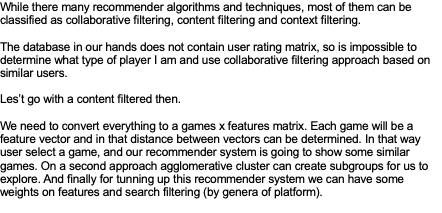
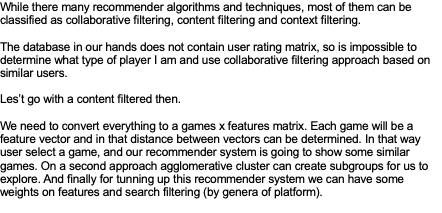
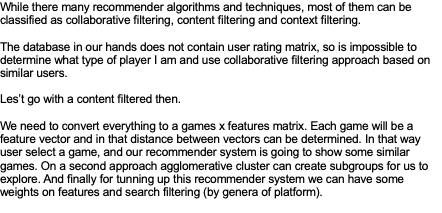
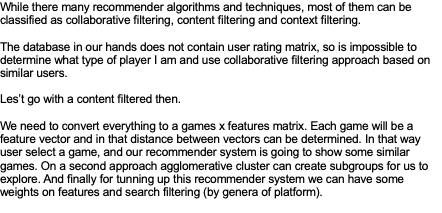

## Preprocessing
On categorical variables we will use two different approaches. One hot encoding is useful for all of them but platform. Unknown will be the category for those null values<br>
Platform is multi-label and one-hot will believe “PC, Wii” is different from “Wii, PC” and won’t capture the necessary information. <br>
Null numeric values are going to be a problem when measuring distances, so we will impute mean value to them. <br>
Numerical variables are going to be normalized and scaled to fit 0-1 interval.
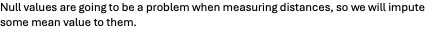
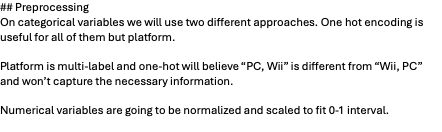
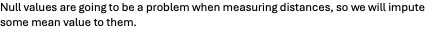
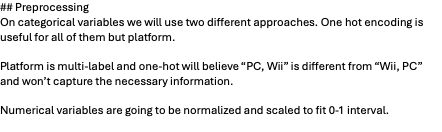
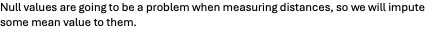
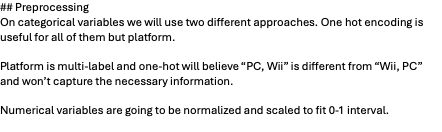
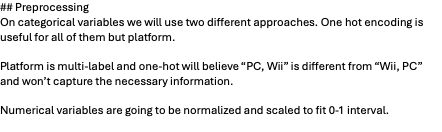
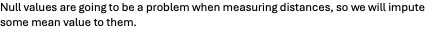

In [16]:
#df.info()
# Diccionary {id: {'name': ..., 'summary': ...}}
# id2info = df.set_index('id')[['name', 'summary', 'publisher']].to_dict(orient='index')

df_info = df.copy()
df_model = df.drop(columns=['name', 'summary','publisher', 'game_page'])

In [17]:
# https://www.geeksforgeeks.org/ml-one-hot-encoding/
from sklearn.preprocessing import OneHotEncoder

cat_cols = df_model.select_dtypes(include=['object'])
cat_cols = cat_cols.fillna('Unknown')

# Use pd.get_dummies() to one-hot encode the categorical columns
cat_cols_encoded = pd.get_dummies(cat_cols, drop_first=True)
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(cat_cols)
one_hot_df = pd.DataFrame(one_hot_encoded, 
                          columns=encoder.get_feature_names_out(cat_cols.columns))
# merge df
df_model = pd.concat([df_model.drop(cat_cols, axis=1), one_hot_df], axis=1)

In [18]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html
from sklearn.preprocessing import MultiLabelBinarizer

df_model['platforms'] = df['platforms'].apply(lambda x: [p.strip() for p in x.split(',')])

mlb = MultiLabelBinarizer()
platform_encoded = mlb.fit_transform(df_model['platforms'])
platform_df = pd.DataFrame(platform_encoded, columns=mlb.classes_, index=df.index)

df_model = df_model.drop(columns=['platforms'])
df_model = pd.concat([df_model, platform_df], axis=1)

In [19]:
print(df_model.isnull().sum())

release_date                  0
metacritic_review_count       0
metacritic_review_score       0
user_review_count          1552
user_review_score          1552
                           ... 
Xbox                          0
Xbox 360                      0
Xbox One                      0
Xbox Series X                 0
iOS (iPhone/iPad)             0
Length: 7427, dtype: int64


In [20]:
# https://scikit-learn.org/stable/modules/impute.html

from sklearn.impute import SimpleImputer

cols_to_impute = ['user_review_count', 'user_review_score']
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df_model[cols_to_impute] = imp.fit_transform(df_model[cols_to_impute])


In [21]:
# cell testing again for null

for i, col in enumerate(df_model.columns, start=1):
    if df_model[col].isnull().sum() >= 1:
        print([col])
        print(df_model[col].isnull().sum())

In [22]:
#numerical column to 0-1 interval
from sklearn.preprocessing import MinMaxScaler

def normalize_column(df: pd.DataFrame, column_name: str) -> np.ndarray:
    """
    Applies MinMax scaling to a single column and returns the scaled 1D array.

    Parameters:
    - df: DataFrame containing the column.
    - column_name: Name of the column to scale.

    Returns:
    - A 1D numpy array with scaled values.
    """
    scaler = MinMaxScaler()
    # Reshape the column to 2D, scale, then flatten back to 1D
    scaled = scaler.fit_transform(df[[column_name]]).flatten()
    return scaled

df_model["metacritic_review_score"] = normalize_column(df_model, "metacritic_review_score")
df_model["metacritic_review_count"] = normalize_column(df_model, "metacritic_review_count")
df_model["user_review_score"] = normalize_column(df_model, "user_review_score")
df_model["user_review_count"] = normalize_column(df_model, "user_review_count")
df_model["release_date"] = normalize_column(df_model, "release_date")

In [23]:
df_model.shape

(13384, 7427)

## Model 1 : Cosine similarity matrix
On this blocks cosine similarity matrix is calculated. We have few lines of code for searching a game, I choose one of my favorites for the test. Index of the selected game is used to the recomendation that will show similar games.

In [24]:
# cosine
from sklearn.metrics.pairwise import cosine_similarity

# numeric = df_model[["release_date", "metacritic_review_score", "user_review_count", "user_review_score"]]
sim_m = cosine_similarity(df_model)

In [25]:
search_query = "Super mario"
matches = df[df['name'].str.contains(search_query, case=False, na=False)]
print(matches[['name']])


                                                   name
3                                    Super Mario Galaxy
4                                  Super Mario Galaxy 2
12                                  Super Mario Odyssey
72           Super Mario Advance 4: Super Mario Bros. 3
98                                 Super Mario 3D World
141                            Super Mario Bros. Wonder
158            Super Mario World: Super Mario Advance 2
168                                Super Mario Sunshine
234               Yoshi's Island: Super Mario Advance 3
338                                 Super Mario 3D Land
410                Super Mario 3D World + Bowser's Fury
480                               New Super Mario Bros.
526                                   Super Mario Maker
597                                 Super Mario Maker 2
728                           New Super Mario Bros. Wii
1218                                     Super Mario 64
1489                                Super Mario 

In [26]:
# Recomendation based on sim_matrix
def recomend (idx_game, sim_matrix, df, info, top_n=3):
    """
    Recomendation function that recieves parameters:
    idx_juego (the game selected by user)
    sim_matrix
    df: Database for model
    info: Database for retriving information
    """
    sim = sim_matrix[idx_game]
    idxs = np.argsort(sim)[::-1]
    print (f'Your Game: {info.iloc[idx_game]}')
    indices = [i for i in idxs if i != idx_game]
    recomendation = info.iloc[indices[:top_n]]
    return recomendation

recomend (158, sim_m, df_model, df_info) # (158: Super Mario World: Super Mario Advance)

Your Game: name                                Super Mario World: Super Mario Advance 2
release_date                                                            2002
game_page                  https://www.metacritic.com/game/super-mario-wo...
summary                    Mario hasn't even had a chance to savor his vi...
metacritic_review_count                                                   28
metacritic_review_score                                                   92
user_review_count                                                        406
user_review_score                                                         89
developer                                                           Nintendo
publisher                                                           Nintendo
platforms                                                   Game Boy Advance
genres                                                         2D Platformer
esrb                          Rated E                           f

,name,release_date,game_page,summary,metacritic_review_count,metacritic_review_score,user_review_count,user_review_score,developer,publisher,platforms,genres,esrb,must_play
234,Yoshi's Island: Super Mario Advance 3,2002,https://www.metacritic.com/game/yoshis-island-...,"When Baby Mario falls from the sky, the big-he...",26,91,258,90,Nintendo,Nintendo,Game Boy Advance,2D Platformer,Rated E for Everyone,1
72,Super Mario Advance 4: Super Mario Bros. 3,2003,https://www.metacritic.com/game/super-mario-ad...,"A combination of exciting platforming action, ...",25,94,457,88,Nintendo,Nintendo,Game Boy Advance,2D Platformer,Rated E for Everyone,1
580,Wario Land 4,2001,https://www.metacritic.com/game/wario-land-4/,"Hey! You! Yeah, you! Listen up when Wario's ta...",17,88,101,87,Nintendo,Nintendo,Game Boy Advance,2D Platformer,Rated E for Everyone,0


## Model 2: KNN 

In [27]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import issparse

def recomend_knn(idx_game, features_matrix, info, top_n=3):
    """
    KNN recommender that supports sparse and dense matrices.
    
    Parameters:
    - idx_game: index of the selected game
    - features_matrix: feature matrix (sparse or dense)
    - info: DataFrame with game info
    - top_n: number of recommendations to return
    """
    # Use sparse matrix as-is, or convert dense to numpy
    if issparse(features_matrix):
        game_vec = features_matrix.getrow(idx_game)
    else:
        features_matrix = features_matrix.to_numpy()
        game_vec = features_matrix[idx_game].reshape(1, -1)

    # Fit KNN
    model_knn = NearestNeighbors(metric='manhattan', algorithm='auto')
    model_knn.fit(features_matrix)

    distances, idxs = model_knn.kneighbors(game_vec, n_neighbors=top_n + 1)

    print(f'Your Game:\n{info.iloc[idx_game]}\n')

    recommended_idxs = idxs.flatten()[1:]
    recomendation = info.iloc[recommended_idxs]
    return recomendation

recomend_knn (158, df_model, df_info) # (158: Super Mario World: Super Mario Advance)

Your Game:
name                                Super Mario World: Super Mario Advance 2
release_date                                                            2002
game_page                  https://www.metacritic.com/game/super-mario-wo...
summary                    Mario hasn't even had a chance to savor his vi...
metacritic_review_count                                                   28
metacritic_review_score                                                   92
user_review_count                                                        406
user_review_score                                                         89
developer                                                           Nintendo
publisher                                                           Nintendo
platforms                                                   Game Boy Advance
genres                                                         2D Platformer
esrb                          Rated E                           f

,name,release_date,game_page,summary,metacritic_review_count,metacritic_review_score,user_review_count,user_review_score,developer,publisher,platforms,genres,esrb,must_play
234,Yoshi's Island: Super Mario Advance 3,2002,https://www.metacritic.com/game/yoshis-island-...,"When Baby Mario falls from the sky, the big-he...",26,91,258,90,Nintendo,Nintendo,Game Boy Advance,2D Platformer,Rated E for Everyone,1
72,Super Mario Advance 4: Super Mario Bros. 3,2003,https://www.metacritic.com/game/super-mario-ad...,"A combination of exciting platforming action, ...",25,94,457,88,Nintendo,Nintendo,Game Boy Advance,2D Platformer,Rated E for Everyone,1
580,Wario Land 4,2001,https://www.metacritic.com/game/wario-land-4/,"Hey! You! Yeah, you! Listen up when Wario's ta...",17,88,101,87,Nintendo,Nintendo,Game Boy Advance,2D Platformer,Rated E for Everyone,0


## Model 3: Hierarchical clustering

In [28]:
"""
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering
from sklearn.cluster import AgglomerativeClustering

print("Hierarchical clustering...")
st = time.time()
n_clusters = 1000  
clustering   = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward").fit(df_model)

print(f"Elapsed time: {time.time() - st:.3f}s")

"""

'\n# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering\nfrom sklearn.cluster import AgglomerativeClustering\n\nprint("Hierarchical clustering...")\nst = time.time()\nn_clusters = 1000  \nclustering   = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward").fit(df_model)\n\nprint(f"Elapsed time: {time.time() - st:.3f}s")\n\n'

In [29]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering
# same method as in AgglomerativeClustering

from scipy.cluster.hierarchy import linkage, dendrogram

print("Hierarchical clustering...")
st = time.time()

Z = linkage(df_model, method='ward')  
print(f"Elapsed time: {time.time() - st:.3f}s")


Hierarchical clustering...
Elapsed time: 440.457s


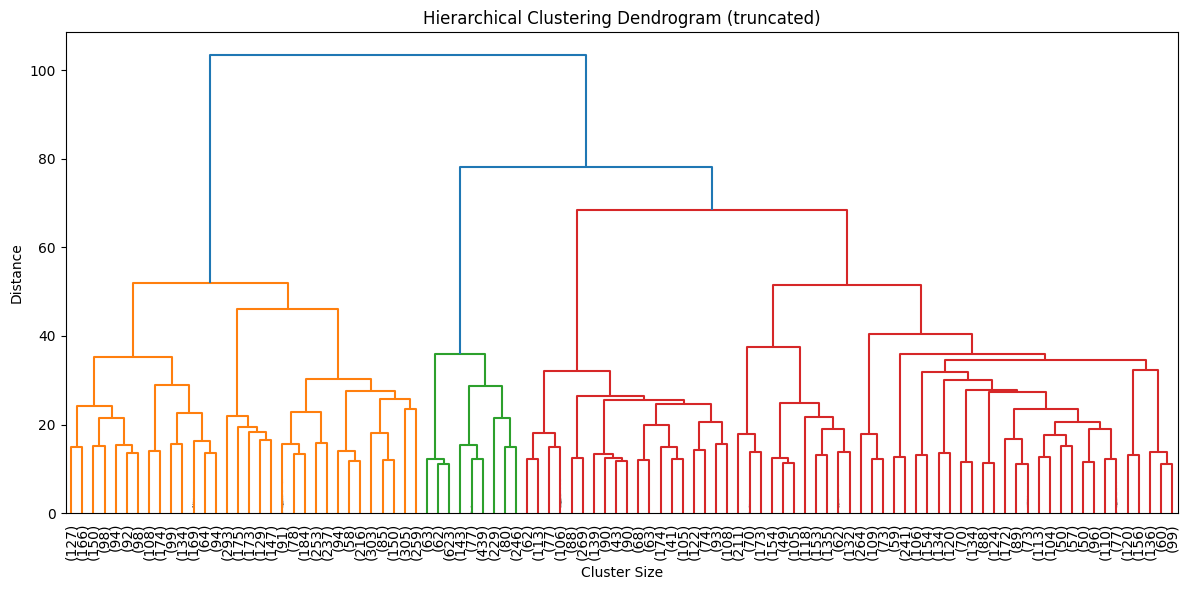

In [30]:
# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='lastp', p=100, leaf_rotation=90., leaf_font_size=10., show_contracted=True)
plt.title("Hierarchical Clustering Dendrogram (truncated)")
plt.xlabel("Cluster Size")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

In [31]:
#Modify dendrogram (numer of clusters for user to pick)
from scipy.cluster.hierarchy import linkage, fcluster

# Cut the dendrogram into 500 clusters
max_clusters = 500
cluster_labels = fcluster(Z, max_clusters, criterion='maxclust')

#Assign these labels to your DataFrame
df_info['game_cluster'] = cluster_labels

In [32]:
def recomend_hc (idx_game, features_matrix, info, top_n=3, order="metacritic_review_score"):
   
    cluster_id = df_info.at[idx_game, 'game_cluster']
    print(f'Your Game: {info.iloc[idx_game]}')
    # Show other games in the same cluster (excluding the selected game)
    cluster_games = info[(info['game_cluster'] == cluster_id)]
    sorted_cluster = cluster_games.sort_values(by=order, ascending=False).head(top_n)
    
    return sorted_cluster

recomend_hc (158, df_model, df_info) # (158: Super Mario World: Super Mario Advance)


Your Game: name                                Super Mario World: Super Mario Advance 2
release_date                                                            2002
game_page                  https://www.metacritic.com/game/super-mario-wo...
summary                    Mario hasn't even had a chance to savor his vi...
metacritic_review_count                                                   28
metacritic_review_score                                                   92
user_review_count                                                        406
user_review_score                                                         89
developer                                                           Nintendo
publisher                                                           Nintendo
platforms                                                   Game Boy Advance
genres                                                         2D Platformer
esrb                          Rated E                           f

,name,release_date,game_page,summary,metacritic_review_count,metacritic_review_score,user_review_count,user_review_score,developer,publisher,platforms,genres,esrb,must_play,game_cluster
42,The Legend of Zelda: A Link to the Past / Four...,2002,https://www.metacritic.com/game/the-legend-of-...,Now you have a link to one of the greatest adv...,30,95,826,89,Nintendo,Nintendo,Game Boy Advance,Open-World Action,Rated E for Everyone,1,412
72,Super Mario Advance 4: Super Mario Bros. 3,2003,https://www.metacritic.com/game/super-mario-ad...,"A combination of exciting platforming action, ...",25,94,457,88,Nintendo,Nintendo,Game Boy Advance,2D Platformer,Rated E for Everyone,1,412
117,Mario Kart: Super Circuit,2001,https://www.metacritic.com/game/mario-kart-sup...,Whoever hands out driver's licenses in the Mus...,24,93,339,77,Intelligent Systems,Nintendo,Game Boy Advance,Auto Racing,Rated E for Everyone,1,412


In [33]:
# Hierarquical cluster sorted by distances.

from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics.pairwise import euclidean_distances
"""
This code is uncomented if 

# Cut the dendrogram into 500 clusters
max_clusters = 500
cluster_labels = fcluster(Z, max_clusters, criterion='maxclust')

#Assign these labels to your DataFrame
df_info['game_cluster'] = cluster_labels
df_info['game_cluster'] = clustering.labels_

"""

def recomend_hc_sorted(idx_game, features_matrix, info, top_n=3):
    if issparse(features_matrix):
        features_matrix = features_matrix.toarray()
        column_names = [f'feature_{i}' for i in range(features_matrix.shape[1])]
        features_matrix = pd.DataFrame(features_matrix, columns=column_names)
    
    # Get the cluster of the selected game
    cluster_id = info.at[idx_game, 'game_cluster']
    
    # Filter games in the same cluster (excluding the selected one)
    same_cluster = info[info['game_cluster'] == cluster_id].copy()
    same_cluster = same_cluster.drop(idx_game)

    # Get vectors
    game_vec = features_matrix.iloc[idx_game].values.reshape(1, -1)
    cluster_vecs = features_matrix.iloc[same_cluster.index]

    # Compute distances
    distances = euclidean_distances(game_vec, cluster_vecs).flatten()

    # Add distance column
    same_cluster['distance'] = distances

    # Sort by distance and return top N
    return same_cluster.sort_values(by='distance').head(top_n)

recomend_hc_sorted (158, df_model, df_info) # (158: Super Mario World: Super Mario Advance)


,name,release_date,game_page,summary,metacritic_review_count,metacritic_review_score,user_review_count,user_review_score,developer,publisher,platforms,genres,esrb,must_play,game_cluster,distance
234,Yoshi's Island: Super Mario Advance 3,2002,https://www.metacritic.com/game/yoshis-island-...,"When Baby Mario falls from the sky, the big-he...",26,91,258,90,Nintendo,Nintendo,Game Boy Advance,2D Platformer,Rated E for Everyone,1,412,0.020406
72,Super Mario Advance 4: Super Mario Bros. 3,2003,https://www.metacritic.com/game/super-mario-ad...,"A combination of exciting platforming action, ...",25,94,457,88,Nintendo,Nintendo,Game Boy Advance,2D Platformer,Rated E for Everyone,1,412,0.047089
580,Wario Land 4,2001,https://www.metacritic.com/game/wario-land-4/,"Hey! You! Yeah, you! Listen up when Wario's ta...",17,88,101,87,Nintendo,Nintendo,Game Boy Advance,2D Platformer,Rated E for Everyone,0,412,1.004557


# Tuning

Until this point i am already satisfied with the results, I can play that games and I believe they are similar, and models are consistent. But my intuition tells me that ‘platform’ is somehow dominating in the decision. In the following blocks let’s try to play with alphas on the weight of the main variables. I must tell this is my arbitrary tune up of alpha taking into account what I believe and want. For example, I don’t care if the system shows games from another platform (I enjoy them all), but I would like genre to be more dominant.
Also, we can go further thinking on 'name', 'summary', and 'genre' and vectorize them, for capturing their true value.


## New database preprossesing


In [34]:
# Database & checking number of words for tfid
df_fullmodel = df.copy()

# Categorical columns processed in df_cat numerical in df_num
df_cat = df_fullmodel.select_dtypes(include=['object']).columns

# Fill "unknown" on categoricals
df_fullmodel[df_cat] = df_fullmodel[df_cat].fillna('Unknown')

df_num = df_fullmodel.select_dtypes(include=['number'])
df_cat = df_fullmodel.select_dtypes(include=['object'])

""""
Cheking 

print((type(df_num)))
print (df_num.isnull().sum())
print ("Name words:")
tf = TfidfVectorizer(max_features=None).fit(cat_cols['name'])
print(tf.vocabulary_.__len__()) 
print ("Sumary words:")
tf = TfidfVectorizer(max_features=None).fit(cat_cols['summary'])
print(tf.vocabulary_.__len__()) 
tf = TfidfVectorizer(max_features=None).fit(cat_cols['developer'])
print(tf.vocabulary_.__len__()) 
tf = TfidfVectorizer(max_features=None).fit(cat_cols['publisher'])
print(tf.vocabulary_.__len__()) 
print ("Genres words:")
tf = TfidfVectorizer(max_features=None).fit(cat_cols['genres'])
print(tf.vocabulary_.__len__()) 

"""

'"\nCheking \n\nprint((type(df_num)))\nprint (df_num.isnull().sum())\nprint ("Name words:")\ntf = TfidfVectorizer(max_features=None).fit(cat_cols[\'name\'])\nprint(tf.vocabulary_.__len__()) \nprint ("Sumary words:")\ntf = TfidfVectorizer(max_features=None).fit(cat_cols[\'summary\'])\nprint(tf.vocabulary_.__len__()) \ntf = TfidfVectorizer(max_features=None).fit(cat_cols[\'developer\'])\nprint(tf.vocabulary_.__len__()) \ntf = TfidfVectorizer(max_features=None).fit(cat_cols[\'publisher\'])\nprint(tf.vocabulary_.__len__()) \nprint ("Genres words:")\ntf = TfidfVectorizer(max_features=None).fit(cat_cols[\'genres\'])\nprint(tf.vocabulary_.__len__()) \n\n'

## Categorical tokenization

In [35]:
# categorical tokenization
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from scipy.sparse import csr_matrix

# Vectorize - returns sparse matrix
tfidf_name = TfidfVectorizer(max_features=100).fit_transform(df_cat['name'])
tfidf_summary = TfidfVectorizer(max_features=300).fit_transform(df_cat['summary'])
tfidf_dev = TfidfVectorizer(max_features=100).fit_transform(df_cat['developer'])
tfidf_pub = TfidfVectorizer(max_features=100).fit_transform(df_cat['publisher'])
tfidf_genres = TfidfVectorizer(max_features=100).fit_transform(df_cat['genres'])

In [36]:
# df_num.isnull().sum()

## Numeric impute and normalize

In [37]:
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import MinMaxScaler
# Fill nan and normalize numeric
cols_to_impute = ['user_review_count', 'user_review_score']
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df_num[cols_to_impute] = imp.fit_transform(df_num[cols_to_impute])

#function scaler normalize the columns
df_num["release_date"] = normalize_column(df_num, "release_date")
df_num["metacritic_review_count"] = normalize_column(df_num, "metacritic_review_count")
df_num["metacritic_review_score"] = normalize_column(df_num, "metacritic_review_score")
df_num["user_review_count"] = normalize_column(df_num, "user_review_count")
df_num["user_review_score"] = normalize_column(df_num, "user_review_score")
df_num["release_date"] = normalize_column(df_num, "release_date")

## Model 1: CSR and cosine similarity

This cells can also modify alpha of the variables. this was left to 1 but you can play with most import personal features.

In [38]:
from scipy.sparse import hstack

# variable                        # alpha * variable
df_num['release_date']            = 1 * df_num['release_date']
df_num['metacritic_review_count'] = 1 * df_num['metacritic_review_count']
df_num['metacritic_review_score'] = 1 * df_num['metacritic_review_score']
df_num['user_review_count']       = 1 * df_num['user_review_count']
df_num['user_review_score']       = 1 * df_num['user_review_score']
df_num['must_play']               = 1 * df_num['must_play']

# numeric to sparse matrix
df_num = df_num.astype('float64')  # Or 'int64' if you're sure they're all integers
csr_df_num = csr_matrix(df_num)

# stack

csr_df_fullmodel = hstack([
    1 * tfidf_name,
    1 * tfidf_summary,
    1 * tfidf_dev,
    1 * tfidf_pub,
    1 * tfidf_genres,
    csr_df_num
])

csr_df_fullmodel.shape

(13384, 706)

In [39]:
# cosine
from sklearn.metrics.pairwise import cosine_similarity

sim_m = cosine_similarity(csr_df_fullmodel)

recomend (158, sim_m, csr_df_fullmodel, df_info) # (158: Super Mario World: Super Mario Advance)


Your Game: name                                Super Mario World: Super Mario Advance 2
release_date                                                            2002
game_page                  https://www.metacritic.com/game/super-mario-wo...
summary                    Mario hasn't even had a chance to savor his vi...
metacritic_review_count                                                   28
metacritic_review_score                                                   92
user_review_count                                                        406
user_review_score                                                         89
developer                                                           Nintendo
publisher                                                           Nintendo
platforms                                                   Game Boy Advance
genres                                                         2D Platformer
esrb                          Rated E                           f

,name,release_date,game_page,summary,metacritic_review_count,metacritic_review_score,user_review_count,user_review_score,developer,publisher,platforms,genres,esrb,must_play,game_cluster
72,Super Mario Advance 4: Super Mario Bros. 3,2003,https://www.metacritic.com/game/super-mario-ad...,"A combination of exciting platforming action, ...",25,94,457,88,Nintendo,Nintendo,Game Boy Advance,2D Platformer,Rated E for Everyone,1,412
234,Yoshi's Island: Super Mario Advance 3,2002,https://www.metacritic.com/game/yoshis-island-...,"When Baby Mario falls from the sky, the big-he...",26,91,258,90,Nintendo,Nintendo,Game Boy Advance,2D Platformer,Rated E for Everyone,1,412
168,Super Mario Sunshine,2002,https://www.metacritic.com/game/super-mario-su...,"When Mario, Peach, and an entourage of Peach's...",61,92,1215,83,Nintendo,Nintendo,GameCube,3D Platformer,Rated E for Everyone,1,466


In [40]:
recomend_knn (158, csr_df_fullmodel, df_info)

Your Game:
name                                Super Mario World: Super Mario Advance 2
release_date                                                            2002
game_page                  https://www.metacritic.com/game/super-mario-wo...
summary                    Mario hasn't even had a chance to savor his vi...
metacritic_review_count                                                   28
metacritic_review_score                                                   92
user_review_count                                                        406
user_review_score                                                         89
developer                                                           Nintendo
publisher                                                           Nintendo
platforms                                                   Game Boy Advance
genres                                                         2D Platformer
esrb                          Rated E                           f

,name,release_date,game_page,summary,metacritic_review_count,metacritic_review_score,user_review_count,user_review_score,developer,publisher,platforms,genres,esrb,must_play,game_cluster
8261,Shift Happens,2017,https://www.metacritic.com/game/shift-happens/,NaN,9,69,9,68,Deck 13,Deck 13,"PC, Xbox One, PlayStation 4, Nintendo Switch",2D Platformer,Rated E for Everyone,0,143
326,LIMBO,2010,https://www.metacritic.com/game/limbo/,[Xbox Live Arcade] Uncertain of his sister's ...,89,90,815,81,PLAYDEAD,PLAYDEAD,"Xbox 360, PlayStation 3, PC, PlayStation Vita,...",2D Platformer,Rated T for Teen,1,327
836,Kirby's Epic Yarn,2010,https://www.metacritic.com/game/kirbys-epic-yarn/,Kirby's wields his yarn through danger in the ...,70,86,338,84,Good-Feel,Nintendo,Wii,2D Platformer,Rated E for Everyone,0,418


In [41]:
recomend_hc (158, csr_df_fullmodel, df_info)

Your Game: name                                Super Mario World: Super Mario Advance 2
release_date                                                            2002
game_page                  https://www.metacritic.com/game/super-mario-wo...
summary                    Mario hasn't even had a chance to savor his vi...
metacritic_review_count                                                   28
metacritic_review_score                                                   92
user_review_count                                                        406
user_review_score                                                         89
developer                                                           Nintendo
publisher                                                           Nintendo
platforms                                                   Game Boy Advance
genres                                                         2D Platformer
esrb                          Rated E                           f

,name,release_date,game_page,summary,metacritic_review_count,metacritic_review_score,user_review_count,user_review_score,developer,publisher,platforms,genres,esrb,must_play,game_cluster
42,The Legend of Zelda: A Link to the Past / Four...,2002,https://www.metacritic.com/game/the-legend-of-...,Now you have a link to one of the greatest adv...,30,95,826,89,Nintendo,Nintendo,Game Boy Advance,Open-World Action,Rated E for Everyone,1,412
72,Super Mario Advance 4: Super Mario Bros. 3,2003,https://www.metacritic.com/game/super-mario-ad...,"A combination of exciting platforming action, ...",25,94,457,88,Nintendo,Nintendo,Game Boy Advance,2D Platformer,Rated E for Everyone,1,412
117,Mario Kart: Super Circuit,2001,https://www.metacritic.com/game/mario-kart-sup...,Whoever hands out driver's licenses in the Mus...,24,93,339,77,Intelligent Systems,Nintendo,Game Boy Advance,Auto Racing,Rated E for Everyone,1,412


In [42]:
recomend_hc_sorted (158, csr_df_fullmodel, df_info)

,name,release_date,game_page,summary,metacritic_review_count,metacritic_review_score,user_review_count,user_review_score,developer,publisher,platforms,genres,esrb,must_play,game_cluster,distance
72,Super Mario Advance 4: Super Mario Bros. 3,2003,https://www.metacritic.com/game/super-mario-ad...,"A combination of exciting platforming action, ...",25,94,457,88,Nintendo,Nintendo,Game Boy Advance,2D Platformer,Rated E for Everyone,1,412,0.982045
234,Yoshi's Island: Super Mario Advance 3,2002,https://www.metacritic.com/game/yoshis-island-...,"When Baby Mario falls from the sky, the big-he...",26,91,258,90,Nintendo,Nintendo,Game Boy Advance,2D Platformer,Rated E for Everyone,1,412,1.418045
1489,Super Mario Advance,2001,https://www.metacritic.com/game/super-mario-ad...,Mario's Game Boy Advance debut gives gamers tw...,19,84,132,81,Nintendo,Nintendo,Game Boy Advance,2D Platformer,Rated E for Everyone,0,412,1.508865


# Discussion 
We could not make a collaborative recommendation system because of the lack of available data in our hands. This is hard to test on performance, and opinions will vary between testers. I can’t think of a way to even test or measure performance here. 
Personally, on my testing I liked the games recommended by only numeric variables.
# Conclusion
Many of these functions are going to be used in future work, and I am glad about it. We made 6 recommender systems for games, and in the future, we can make more interactive code for making a real searching app for similar games or play with alphas on weights of features for developing a more accurate system.

## This code was made with the helping hands of AI and some are textually used. 